# SQL Practice Notebook - Finance & Banking

This notebook provides a complete SQL environment with banking and finance tables for practicing SQL queries.

## Setup
Run the cells below to:
1. Install required packages
2. Create a SQLite database
3. Create sample banking tables with data
4. Start querying!


In [40]:
# Install required packages (run this once)
%pip install ipython-sql sqlalchemy


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: C:\Users\ethan\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [41]:
# Load SQL extension (must run after installing ipython-sql)
%load_ext sql

# If you get an error, try:
# import sys
# !{sys.executable} -m pip install ipython-sql sqlalchemy
# %load_ext sql


The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [42]:
import sqlite3
import pandas as pd
from sqlalchemy import create_engine
import sql.run
import prettytable

# Fix for KeyError with prettytable - Patch ResultSet to handle style errors
_original_resultset_init = sql.run.ResultSet.__init__

def _patched_resultset_init(self, sqlaproxy, config):
    """Patched init that handles missing prettytable styles gracefully"""
    # Initialize the list with data first
    list.__init__(self, sqlaproxy.fetchall())
    
    # Get field names properly - handle both callable and view objects
    try:
        keys = sqlaproxy.keys()
        # If keys is a view (like RMKeyView), convert to list
        if not callable(keys) and hasattr(keys, '__iter__'):
            keys = list(keys)
        elif callable(keys):
            keys = keys()
        else:
            # If it's already a list or similar, use as is
            keys = list(keys) if hasattr(keys, '__iter__') else keys
    except (AttributeError, TypeError):
        # Fallback: get keys from first row if available
        keys = list(self[0].keys()) if self and len(self) > 0 else []
    
    self.field_names = sql.run.unduplicate_field_names(keys)
    
    # IMPORTANT: Set keys attribute for pandas DataFrame conversion (autopandas)
    # This makes self.keys return the field names
    self.keys = self.field_names
    
    # Try to get a valid style - completely bypass style lookup issues
    style_obj = None
    requested_style = (config.style.upper() if config.style else 'DEFAULT')
    
    # Check if style exists in prettytable
    if requested_style in prettytable.__dict__:
        try:
            style_obj = prettytable.__dict__[requested_style]
        except (KeyError, AttributeError):
            pass
    
    # If no valid style found, try fallbacks
    if style_obj is None:
        for attr_name in ['SINGLE_BORDER', 'DOUBLE_BORDER', 'PLAIN_COLUMNS', 
                          'MSWORD_FRIENDLY', 'MARKDOWN']:
            if attr_name in prettytable.__dict__:
                try:
                    style_obj = prettytable.__dict__[attr_name]
                    break
                except (KeyError, AttributeError):
                    continue
    
    # Create PrettyTable - try with style first, fallback to no style
    try:
        if style_obj is not None:
            self.pretty = prettytable.PrettyTable(self.field_names, style=style_obj)
        else:
            self.pretty = prettytable.PrettyTable(self.field_names)
    except (TypeError, AttributeError, KeyError):
        # Last resort: create without any style
        self.pretty = prettytable.PrettyTable(self.field_names)
    
    # Add rows
    for row in self:
        self.pretty.add_row(row)

sql.run.ResultSet.__init__ = _patched_resultset_init

# Create SQLite database
conn = sqlite3.connect('practice_database.db')
cursor = conn.cursor()

# Connect to database for SQL magic commands
# This connects the %sql magic to your database
%sql sqlite:///practice_database.db

# Configure SQL output to use pandas DataFrames (recommended)
# This bypasses PrettyTable entirely and returns DataFrames
%config SqlMagic.autopandas = True

# Alternative: You can also query directly with pandas (no PrettyTable issues)
# Example: pd.read_sql_query("SELECT * FROM customers", conn)
print("✅ Database connection established!")
print("💡 Tip: With autopandas=True, SQL queries will return pandas DataFrames")
print("💡 Alternative: Use pd.read_sql_query('SELECT ...', conn) for direct queries")


✅ Database connection established!
💡 Tip: With autopandas=True, SQL queries will return pandas DataFrames
💡 Alternative: Use pd.read_sql_query('SELECT ...', conn) for direct queries


## Create Banking Tables

The following cells create sample tables with realistic banking data:
- **customers**: Customer information
- **accounts**: Bank accounts (checking, savings, etc.)
- **transactions**: Financial transactions
- **loans**: Loan information
- **branches**: Bank branch locations


In [43]:
# Create customers table
cursor.execute('''
CREATE TABLE IF NOT EXISTS customers (
    customer_id INTEGER PRIMARY KEY,
    first_name TEXT NOT NULL,
    last_name TEXT NOT NULL,
    email TEXT UNIQUE,
    phone TEXT,
    date_of_birth DATE,
    address TEXT,
    city TEXT,
    state TEXT,
    zip_code TEXT,
    account_opened_date DATE
)
''')

# Create branches table
cursor.execute('''
CREATE TABLE IF NOT EXISTS branches (
    branch_id INTEGER PRIMARY KEY,
    branch_name TEXT NOT NULL,
    address TEXT,
    city TEXT,
    state TEXT,
    zip_code TEXT,
    manager_name TEXT
)
''')

# Create accounts table
cursor.execute('''
CREATE TABLE IF NOT EXISTS accounts (
    account_id INTEGER PRIMARY KEY,
    customer_id INTEGER NOT NULL,
    account_number TEXT UNIQUE NOT NULL,
    account_type TEXT NOT NULL,
    balance DECIMAL(12, 2) DEFAULT 0.00,
    interest_rate DECIMAL(5, 4),
    branch_id INTEGER,
    opened_date DATE,
    status TEXT DEFAULT 'Active',
    FOREIGN KEY (customer_id) REFERENCES customers(customer_id),
    FOREIGN KEY (branch_id) REFERENCES branches(branch_id)
)
''')

# Create transactions table
cursor.execute('''
CREATE TABLE IF NOT EXISTS transactions (
    transaction_id INTEGER PRIMARY KEY,
    account_id INTEGER NOT NULL,
    transaction_date DATE NOT NULL,
    transaction_type TEXT NOT NULL,
    amount DECIMAL(12, 2) NOT NULL,
    description TEXT,
    balance_after DECIMAL(12, 2),
    FOREIGN KEY (account_id) REFERENCES accounts(account_id)
)
''')

# Create loans table
cursor.execute('''
CREATE TABLE IF NOT EXISTS loans (
    loan_id INTEGER PRIMARY KEY,
    customer_id INTEGER NOT NULL,
    account_id INTEGER,
    loan_type TEXT NOT NULL,
    principal_amount DECIMAL(12, 2) NOT NULL,
    interest_rate DECIMAL(5, 4) NOT NULL,
    loan_term_months INTEGER,
    monthly_payment DECIMAL(10, 2),
    remaining_balance DECIMAL(12, 2),
    loan_date DATE,
    status TEXT DEFAULT 'Active',
    branch_id INTEGER,
    FOREIGN KEY (customer_id) REFERENCES customers(customer_id),
    FOREIGN KEY (account_id) REFERENCES accounts(account_id),
    FOREIGN KEY (branch_id) REFERENCES branches(branch_id)
)
''')

conn.commit()
print("Banking tables created successfully!")


Banking tables created successfully!


In [44]:
# Insert sample data into branches
branches_data = [
    (1, 'Main Street Branch', '123 Main St', 'New York', 'NY', '10001', 'John Smith'),
    (2, 'Downtown Branch', '456 Broadway', 'Chicago', 'IL', '60601', 'Sarah Johnson'),
    (3, 'Financial District', '789 Wall St', 'New York', 'NY', '10005', 'Michael Williams'),
    (4, 'Westside Branch', '321 Sunset Blvd', 'Los Angeles', 'CA', '90028', 'Emily Brown'),
    (5, 'North Branch', '654 Market St', 'San Francisco', 'CA', '94102', 'David Jones')
]

cursor.executemany('''
INSERT OR REPLACE INTO branches (branch_id, branch_name, address, city, state, zip_code, manager_name)
VALUES (?, ?, ?, ?, ?, ?, ?)
''', branches_data)

# Insert sample data into customers
customers_data = [
    (1, 'Alice', 'Cooper', 'alice.cooper@email.com', '555-0101', '1985-03-15', '123 Oak Ave', 'New York', 'NY', '10001', '2020-01-15'),
    (2, 'Bob', 'Wilson', 'bob.wilson@email.com', '555-0102', '1990-07-22', '456 Elm St', 'Chicago', 'IL', '60601', '2019-05-20'),
    (3, 'Charlie', 'Brown', 'charlie.brown@email.com', '555-0103', '1988-11-08', '789 Pine Rd', 'Los Angeles', 'CA', '90028', '2021-03-10'),
    (4, 'Diana', 'Prince', 'diana.prince@email.com', '555-0104', '1992-02-14', '321 Maple Dr', 'New York', 'NY', '10005', '2020-08-30'),
    (5, 'Edward', 'Norton', 'edward.norton@email.com', '555-0105', '1987-09-25', '654 Cedar Ln', 'San Francisco', 'CA', '94102', '2019-11-12'),
    (6, 'Fiona', 'Apple', 'fiona.apple@email.com', '555-0106', '1995-04-18', '987 Birch Way', 'Chicago', 'IL', '60601', '2022-01-05'),
    (7, 'George', 'Clooney', 'george.clooney@email.com', '555-0107', '1983-12-30', '147 Spruce St', 'Los Angeles', 'CA', '90028', '2020-06-18'),
    (8, 'Helen', 'Hunt', 'helen.hunt@email.com', '555-0108', '1991-08-07', '258 Willow Ave', 'New York', 'NY', '10001', '2021-09-22'),
    (9, 'Ian', 'McKellen', 'ian.mckellen@email.com', '555-0109', '1986-01-20', '369 Ash Blvd', 'San Francisco', 'CA', '94102', '2019-04-14'),
    (10, 'Julia', 'Roberts', 'julia.roberts@email.com', '555-0110', '1989-06-12', '741 Cherry Ct', 'Chicago', 'IL', '60601', '2020-12-03')
]

cursor.executemany('''
INSERT OR REPLACE INTO customers (customer_id, first_name, last_name, email, phone, date_of_birth, address, city, state, zip_code, account_opened_date)
VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
''', customers_data)

conn.commit()
print("Branches and customers data inserted!")


Branches and customers data inserted!


In [45]:
# Insert sample data into accounts
accounts_data = [
    (1, 1, 'CHK001234567', 'Checking', 5420.50, 0.0000, 1, '2020-01-15', 'Active'),
    (2, 1, 'SAV001234568', 'Savings', 12500.00, 0.0250, 1, '2020-01-15', 'Active'),
    (3, 2, 'CHK002345679', 'Checking', 3280.75, 0.0000, 2, '2019-05-20', 'Active'),
    (4, 2, 'SAV002345680', 'Savings', 8500.00, 0.0250, 2, '2019-05-20', 'Active'),
    (5, 3, 'CHK003456781', 'Checking', 1890.25, 0.0000, 4, '2021-03-10', 'Active'),
    (6, 4, 'CHK004567892', 'Checking', 6750.00, 0.0000, 3, '2020-08-30', 'Active'),
    (7, 4, 'SAV004567893', 'Savings', 15000.00, 0.0300, 3, '2020-08-30', 'Active'),
    (8, 5, 'CHK005678903', 'Checking', 4200.50, 0.0000, 5, '2019-11-12', 'Active'),
    (9, 6, 'CHK006789014', 'Checking', 950.00, 0.0000, 2, '2022-01-05', 'Active'),
    (10, 7, 'CHK007890125', 'Checking', 11200.75, 0.0000, 4, '2020-06-18', 'Active'),
    (11, 7, 'SAV007890126', 'Savings', 25000.00, 0.0300, 4, '2020-06-18', 'Active'),
    (12, 8, 'CHK008901236', 'Checking', 2340.00, 0.0000, 1, '2021-09-22', 'Active'),
    (13, 9, 'CHK009012347', 'Checking', 5670.25, 0.0000, 5, '2019-04-14', 'Active'),
    (14, 9, 'SAV009012348', 'Savings', 18000.00, 0.0250, 5, '2019-04-14', 'Active'),
    (15, 10, 'CHK010123458', 'Checking', 1450.50, 0.0000, 2, '2020-12-03', 'Active')
]

cursor.executemany('''
INSERT OR REPLACE INTO accounts (account_id, customer_id, account_number, account_type, balance, interest_rate, branch_id, opened_date, status)
VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)
''', accounts_data)

conn.commit()
print("Accounts data inserted!")


Accounts data inserted!


In [46]:
# Insert sample data into transactions
transactions_data = [
    (1, 1, '2024-01-15', 'Deposit', 5000.00, 'Initial deposit', 5000.00),
    (2, 1, '2024-01-20', 'Withdrawal', -250.00, 'ATM withdrawal', 4750.00),
    (3, 1, '2024-01-25', 'Deposit', 1200.00, 'Salary deposit', 5950.00),
    (4, 1, '2024-02-01', 'Withdrawal', -529.50, 'Check payment', 5420.50),
    (5, 2, '2024-01-15', 'Deposit', 10000.00, 'Initial deposit', 10000.00),
    (6, 2, '2024-02-01', 'Deposit', 2500.00, 'Monthly savings', 12500.00),
    (7, 3, '2024-01-16', 'Deposit', 3000.00, 'Initial deposit', 3000.00),
    (8, 3, '2024-01-22', 'Withdrawal', -280.75, 'Debit card purchase', 2719.25),
    (9, 3, '2024-01-28', 'Deposit', 561.50, 'Transfer from savings', 3280.75),
    (10, 4, '2024-01-18', 'Deposit', 8000.00, 'Initial deposit', 8000.00),
    (11, 4, '2024-02-01', 'Deposit', 500.00, 'Monthly savings', 8500.00),
    (12, 5, '2024-01-17', 'Deposit', 2000.00, 'Initial deposit', 2000.00),
    (13, 5, '2024-01-25', 'Withdrawal', -109.75, 'ATM withdrawal', 1890.25),
    (14, 6, '2024-01-18', 'Deposit', 7000.00, 'Initial deposit', 7000.00),
    (15, 6, '2024-01-30', 'Withdrawal', -250.00, 'Check payment', 6750.00),
    (16, 7, '2024-01-18', 'Deposit', 15000.00, 'Initial deposit', 15000.00),
    (17, 8, '2024-01-19', 'Deposit', 4500.00, 'Initial deposit', 4500.00),
    (18, 8, '2024-01-28', 'Withdrawal', -299.50, 'Debit card purchase', 4200.50),
    (19, 9, '2024-01-20', 'Deposit', 1000.00, 'Initial deposit', 1000.00),
    (20, 9, '2024-01-25', 'Withdrawal', -50.00, 'ATM withdrawal', 950.00),
    (21, 10, '2024-01-21', 'Deposit', 12000.00, 'Initial deposit', 12000.00),
    (22, 10, '2024-01-30', 'Withdrawal', -799.25, 'Check payment', 11200.75),
    (23, 11, '2024-01-21', 'Deposit', 25000.00, 'Initial deposit', 25000.00),
    (24, 12, '2024-01-22', 'Deposit', 2500.00, 'Initial deposit', 2500.00),
    (25, 12, '2024-01-28', 'Withdrawal', -160.00, 'Debit card purchase', 2340.00),
    (26, 13, '2024-01-23', 'Deposit', 6000.00, 'Initial deposit', 6000.00),
    (27, 13, '2024-01-30', 'Withdrawal', -329.75, 'ATM withdrawal', 5670.25),
    (28, 14, '2024-01-23', 'Deposit', 18000.00, 'Initial deposit', 18000.00),
    (29, 15, '2024-01-24', 'Deposit', 1500.00, 'Initial deposit', 1500.00),
    (30, 15, '2024-01-29', 'Withdrawal', -49.50, 'Debit card purchase', 1450.50)
]

cursor.executemany('''
INSERT OR REPLACE INTO transactions (transaction_id, account_id, transaction_date, transaction_type, amount, description, balance_after)
VALUES (?, ?, ?, ?, ?, ?, ?)
''', transactions_data)

# Insert sample data into loans
loans_data = [
    (1, 1, 2, 'Mortgage', 350000.00, 0.0375, 360, 1620.50, 345000.00, '2020-02-01', 'Active', 1),
    (2, 2, 4, 'Auto Loan', 25000.00, 0.0450, 60, 465.25, 22000.00, '2019-08-15', 'Active', 2),
    (3, 4, 7, 'Personal Loan', 15000.00, 0.0850, 36, 475.00, 12000.00, '2020-10-01', 'Active', 3),
    (4, 5, 8, 'Mortgage', 425000.00, 0.0350, 360, 1908.75, 410000.00, '2019-12-10', 'Active', 5),
    (5, 7, 11, 'Home Equity', 75000.00, 0.0550, 120, 810.50, 70000.00, '2020-08-20', 'Active', 4),
    (6, 9, 14, 'Auto Loan', 32000.00, 0.0425, 72, 495.75, 28000.00, '2019-06-05', 'Active', 5)
]

cursor.executemany('''
INSERT OR REPLACE INTO loans (loan_id, customer_id, account_id, loan_type, principal_amount, interest_rate, loan_term_months, monthly_payment, remaining_balance, loan_date, status, branch_id)
VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
''', loans_data)

conn.commit()
print("Transactions and loans data inserted!")
print("\n✅ Database setup complete! All banking tables are ready for querying.")


Transactions and loans data inserted!

✅ Database setup complete! All banking tables are ready for querying.


## Database Schema & ERD

### Entity Relationship Diagram

The banking database consists of 5 main tables with the following relationships:

```
CUSTOMERS (1) ──< (N) ACCOUNTS
CUSTOMERS (1) ──< (N) LOANS
BRANCHES (1) ──< (N) ACCOUNTS
BRANCHES (1) ──< (N) LOANS
ACCOUNTS (1) ──< (N) TRANSACTIONS
ACCOUNTS (1) ──< (N) LOANS (optional link)
```

**Key Relationships:**
- One customer can have multiple accounts and loans
- One branch can serve multiple accounts and process multiple loans
- One account can have many transactions
- Loans can optionally be linked to a specific account

For a detailed ERD diagram, see `ERD_Banking_Database.md` in this folder.

### View Table Structures

Let's see what tables we have and their schemas:


## 3 Basic JOIN Queries

Practice these fundamental JOIN operations:

### JOIN Example 1: INNER JOIN - Customers with Their Accounts


In [93]:
%%sql
-- Join accounts with transactions
SELECT 
    a.account_number,
    a.account_type,
    t.transaction_type
FROM accounts a
INNER JOIN transactions t ON a.account_id = t.account_id
ORDER BY a.account_type, t.transaction_type DESC;

 * sqlite:///practice_database.db
Done.


,account_number,account_type,transaction_type
0,CHK001234567,Checking,Withdrawal
1,CHK001234567,Checking,Withdrawal
2,CHK002345679,Checking,Withdrawal
3,CHK003456781,Checking,Withdrawal
4,CHK004567892,Checking,Withdrawal
5,CHK005678903,Checking,Withdrawal
6,CHK006789014,Checking,Withdrawal
7,CHK007890125,Checking,Withdrawal
8,CHK008901236,Checking,Withdrawal
9,CHK009012347,Checking,Withdrawal


In [85]:
%%sql
-- Join customers with their accounts
SELECT 
    c.first_name || ' ' || c.last_name AS customer_name,
    a.account_number,
    a.account_type,
    a.balance
FROM customers c
INNER JOIN accounts a ON c.customer_id = a.customer_id
ORDER BY c.last_name, a.balance DESC;


 * sqlite:///practice_database.db
Done.


,customer_name,account_number,account_type,balance
0,Fiona Apple,CHK006789014,Checking,950.00
1,Charlie Brown,CHK003456781,Checking,1890.25
2,George Clooney,SAV007890126,Savings,25000.00
3,George Clooney,CHK007890125,Checking,11200.75
4,Alice Cooper,SAV001234568,Savings,12500.00
5,Alice Cooper,CHK001234567,Checking,5420.50
6,Helen Hunt,CHK008901236,Checking,2340.00
7,Ian McKellen,SAV009012348,Savings,18000.00
8,Ian McKellen,CHK009012347,Checking,5670.25
9,Edward Norton,CHK005678903,Checking,4200.50


### Visual ERD Diagram

Run the cell below to generate a visual Entity Relationship Diagram:


## 5 Intermediate SELECT Queries (Before JOINs)

Practice these queries to build your SQL skills before moving to JOINs:

### Example 1: Filtering with Multiple Conditions
%%sql
SELECT *
FROM accounts
WHERE balance 

In [73]:
%%sql
-- Find savings accounts with balance between $10,000 and $20,000
SELECT account_number, balance, interest_rate
FROM accounts
WHERE account_type = 'Savings' 
  AND balance BETWEEN 10000 AND 20000
ORDER BY balance DESC;


 * sqlite:///practice_database.db
Done.


,account_number,balance,interest_rate
0,SAV009012348,18000,0.025
1,SAV004567893,15000,0.030
2,SAV001234568,12500,0.025


In [74]:
%%sql
-- Find accounts with balance above the average
SELECT 
    account_number,
    account_type,
    balance
FROM accounts
WHERE balance > (
    SELECT AVG(balance) 
    FROM accounts
)
ORDER BY balance DESC;


 * sqlite:///practice_database.db
Done.


,account_number,account_type,balance
0,SAV007890126,Savings,25000.00
1,SAV009012348,Savings,18000.00
2,SAV004567893,Savings,15000.00
3,SAV001234568,Savings,12500.00
4,CHK007890125,Checking,11200.75
5,SAV002345680,Savings,8500.00


### 10. IN and NOT IN


In [76]:
%%sql
-- Find customers from specific cities # chicago, new york
select * 
FROM customers 
WHERE city = 'Chicago' or 'New York';



 * sqlite:///practice_database.db
Done.


,customer_id,first_name,last_name,email,phone,date_of_birth,address,city,state,zip_code,account_opened_date
0,2,Bob,Wilson,bob.wilson@email.com,555-0102,1990-07-22,456 Elm St,Chicago,IL,60601,2019-05-20
1,6,Fiona,Apple,fiona.apple@email.com,555-0106,1995-04-18,987 Birch Way,Chicago,IL,60601,2022-01-05
2,10,Julia,Roberts,julia.roberts@email.com,555-0110,1989-06-12,741 Cherry Ct,Chicago,IL,60601,2020-12-03


. 

In [77]:
%%sql
-- Find accounts starting with 'SAV' (Savings accounts)
SELECT *
FROM Accounts
WHERE account_type is "Savings"

 * sqlite:///practice_database.db
Done.


,account_id,customer_id,account_number,account_type,balance,interest_rate,branch_id,opened_date,status
0,2,1,SAV001234568,Savings,12500,0.025,1,2020-01-15,Active
1,4,2,SAV002345680,Savings,8500,0.025,2,2019-05-20,Active
2,7,4,SAV004567893,Savings,15000,0.030,3,2020-08-30,Active
3,11,7,SAV007890126,Savings,25000,0.030,4,2020-06-18,Active
4,14,9,SAV009012348,Savings,18000,0.025,5,2019-04-14,Active


### 12. DISTINCT - Remove Duplicates


In [80]:
%%sql
-- Find all unique branch name  
SELECT DISTINCT city, zip_code, branch_name
FROM Branches
ORDER BY city;


 * sqlite:///practice_database.db
Done.


,city,zip_code,branch_name
0,Chicago,60601,Downtown Branch
1,Los Angeles,90028,Westside Branch
2,New York,10001,Main Street Branch
3,New York,10005,Financial District
4,San Francisco,94102,North Branch


Found 0 accounts with negative balances



,account_number,account_type,balance,interest_rate,customer_id


No negative balance accounts found. Creating visualization with all accounts for demonstration.
You can modify account balances to negative values to see the visualization with real data.



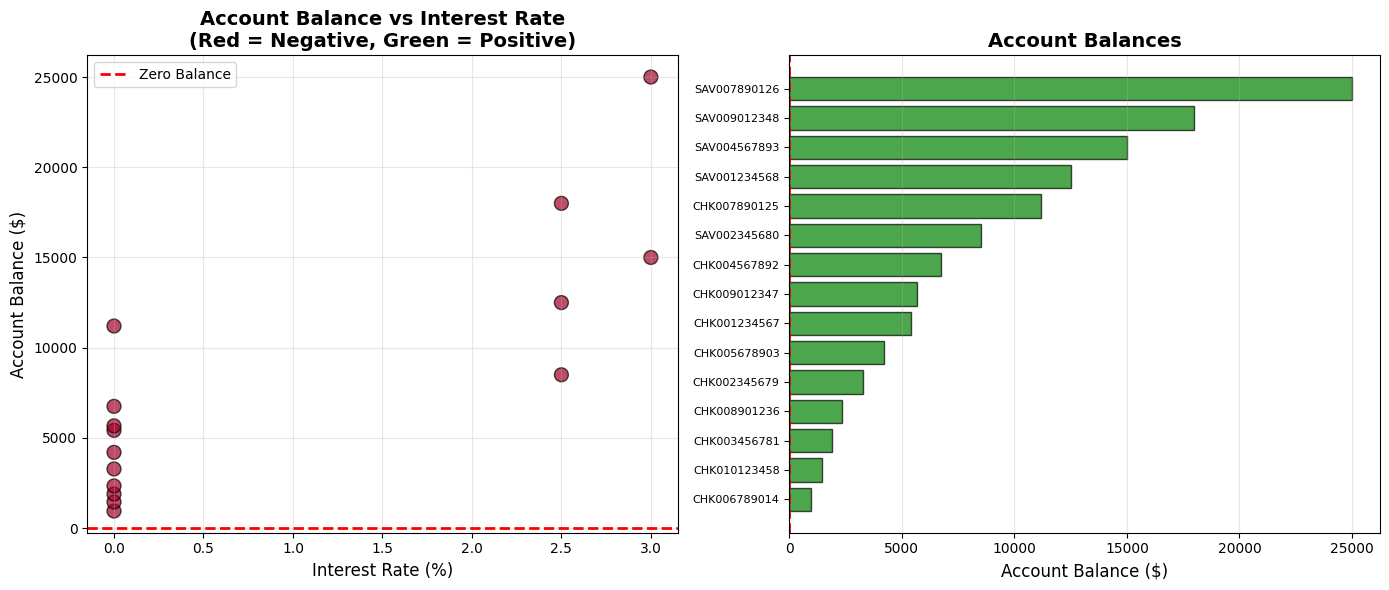


💡 To see negative accounts, you can update account balances:
   UPDATE accounts SET balance = -500 WHERE account_id = 1;


In [95]:
import matplotlib.pyplot as plt
import numpy as np

# If no negative accounts exist, let's create some sample data for demonstration
# or use all accounts to show the concept
if len(negative_accounts_df) == 0:
    print("No negative balance accounts found. Creating visualization with all accounts for demonstration.")
    print("You can modify account balances to negative values to see the visualization with real data.\n")
    
    # Get all accounts for demonstration
    all_accounts_df = pd.read_sql_query("""
        SELECT account_number, account_type, balance, interest_rate 
        FROM accounts 
        ORDER BY balance ASC
    """, conn)
    
    # Create visualization showing balance vs interest rate
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot 1: Scatter plot of Balance vs Interest Rate
    scatter = ax1.scatter(all_accounts_df['interest_rate'] * 100, 
                         all_accounts_df['balance'], 
                         c=all_accounts_df['balance'] < 0,
                         cmap='RdYlGn',
                         s=100,
                         alpha=0.7,
                         edgecolors='black',
                         linewidth=1)
    
    ax1.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Zero Balance')
    ax1.set_xlabel('Interest Rate (%)', fontsize=12)
    ax1.set_ylabel('Account Balance ($)', fontsize=12)
    ax1.set_title('Account Balance vs Interest Rate\n(Red = Negative, Green = Positive)', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Plot 2: Bar chart showing negative balance accounts (if any) or all accounts
    colors = ['red' if bal < 0 else 'green' for bal in all_accounts_df['balance']]
    ax2.barh(range(len(all_accounts_df)), 
             all_accounts_df['balance'], 
             color=colors,
             alpha=0.7,
             edgecolor='black')
    ax2.axvline(x=0, color='red', linestyle='--', linewidth=2)
    ax2.set_yticks(range(len(all_accounts_df)))
    ax2.set_yticklabels(all_accounts_df['account_number'], fontsize=8)
    ax2.set_xlabel('Account Balance ($)', fontsize=12)
    ax2.set_title('Account Balances', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()
    
    print("\n💡 To see negative accounts, you can update account balances:")
    print("   UPDATE accounts SET balance = -500 WHERE account_id = 1;")
    
else:
    # Visualize negative accounts
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot 1: Scatter plot - Balance vs Interest Rate for negative accounts
    scatter = ax1.scatter(negative_accounts_df['interest_rate'] * 100, 
                         negative_accounts_df['balance'], 
                         s=150,
                         c='red',
                         alpha=0.7,
                         edgecolors='darkred',
                         linewidth=2)
    
    ax1.axhline(y=0, color='black', linestyle='--', linewidth=2)
    ax1.set_xlabel('Interest Rate (%)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Account Balance ($)', fontsize=12, fontweight='bold')
    ax1.set_title('Negative Balance Accounts:\nBalance vs Interest Rate', 
                  fontsize=14, fontweight='bold', color='darkred')
    ax1.grid(True, alpha=0.3)
    
    # Add account numbers as labels
    for idx, row in negative_accounts_df.iterrows():
        ax1.annotate(row['account_number'], 
                    (row['interest_rate'] * 100, row['balance']),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8, fontweight='bold')
    
    # Plot 2: Bar chart showing negative balances
    bars = ax2.barh(range(len(negative_accounts_df)), 
                    negative_accounts_df['balance'], 
                    color='red',
                    alpha=0.7,
                    edgecolor='darkred',
                    linewidth=2)
    
    ax2.axvline(x=0, color='black', linestyle='--', linewidth=2)
    ax2.set_yticks(range(len(negative_accounts_df)))
    ax2.set_yticklabels([f"{row['account_number']}\n({row['account_type']})" 
                         for _, row in negative_accounts_df.iterrows()], 
                        fontsize=9)
    ax2.set_xlabel('Account Balance ($)', fontsize=12, fontweight='bold')
    ax2.set_title('Negative Balance Accounts', fontsize=14, fontweight='bold', color='darkred')
    ax2.grid(True, alpha=0.3, axis='x')
    
    # Add value labels on bars
    for i, (idx, row) in enumerate(negative_accounts_df.iterrows()):
        ax2.text(row['balance'] - 50, i, f'${row["balance"]:.2f}', 
                va='center', ha='right', fontweight='bold', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print("\n" + "="*60)
    print("SUMMARY STATISTICS FOR NEGATIVE BALANCE ACCOUNTS")
    print("="*60)
    print(f"Total Negative Accounts: {len(negative_accounts_df)}")
    print(f"Total Negative Balance: ${negative_accounts_df['balance'].sum():,.2f}")
    print(f"Average Negative Balance: ${negative_accounts_df['balance'].mean():,.2f}")
    print(f"Average Interest Rate: {negative_accounts_df['interest_rate'].mean() * 100:.2f}%")
    print(f"Account Types: {', '.join(negative_accounts_df['account_type'].unique())}")


## Accounts by City - Heatmap Visualization

Count accounts by city and visualize with a heatmap:


In [96]:
# Query to count accounts by city
accounts_by_city_query = """
SELECT 
    b.city,
    b.state,
    COUNT(a.account_id) AS account_count,
    SUM(a.balance) AS total_balance,
    AVG(a.balance) AS avg_balance
FROM accounts a
JOIN branches b ON a.branch_id = b.branch_id
GROUP BY b.city, b.state
ORDER BY account_count DESC;
"""

# Get the data
accounts_by_city_df = pd.read_sql_query(accounts_by_city_query, conn)

print("Accounts by City:")
print("="*60)
print(accounts_by_city_df.to_string(index=False))
print("="*60)


Accounts by City:
         city state  account_count  total_balance  avg_balance
     New York    NY              5       42010.50    8402.1000
      Chicago    IL              4       14181.25    3545.3125
  Los Angeles    CA              3       38091.00   12697.0000
San Francisco    CA              3       27870.75    9290.2500


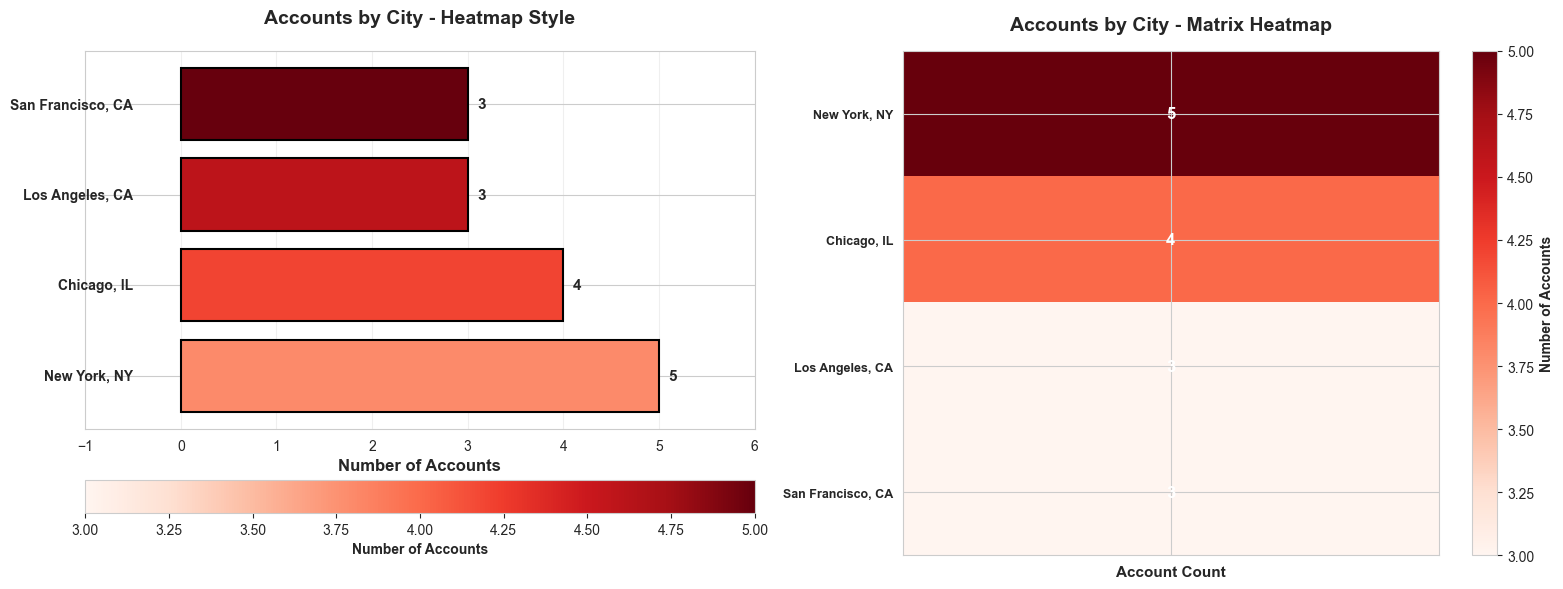


SUMMARY
Total Cities: 4
Total Accounts: 15
City with Most Accounts: New York (5 accounts)
City with Least Accounts: Los Angeles (3 accounts)


In [97]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Prepare data for heatmap
# Create a pivot table for heatmap visualization
cities = accounts_by_city_df['city'].values
account_counts = accounts_by_city_df['account_count'].values
states = accounts_by_city_df['state'].values

# Plot 1: Horizontal Bar Chart (Heatmap style)
colors = plt.cm.Reds(np.linspace(0.4, 1, len(account_counts)))
bars = ax1.barh(range(len(cities)), account_counts, color=colors, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for i, (city, count, state) in enumerate(zip(cities, account_counts, states)):
    ax1.text(count + 0.1, i, f'{int(count)}', 
            va='center', fontweight='bold', fontsize=11)
    ax1.text(-0.5, i, f'{city}, {state}', 
            va='center', ha='right', fontsize=10, fontweight='bold')

ax1.set_yticks(range(len(cities)))
ax1.set_yticklabels([])  # We'll use the text labels instead
ax1.set_xlabel('Number of Accounts', fontsize=12, fontweight='bold')
ax1.set_title('Accounts by City - Heatmap Style', fontsize=14, fontweight='bold', pad=20)
ax1.grid(True, alpha=0.3, axis='x')
ax1.set_xlim(-1, max(account_counts) * 1.2)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, 
                           norm=plt.Normalize(vmin=min(account_counts), vmax=max(account_counts)))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax1, orientation='horizontal', pad=0.1)
cbar.set_label('Number of Accounts', fontsize=10, fontweight='bold')

# Plot 2: Heatmap Matrix (if we have multiple dimensions)
# Create a matrix showing account distribution
if len(accounts_by_city_df) > 1:
    # Create a simple heatmap showing account counts
    heatmap_data = accounts_by_city_df[['city', 'account_count', 'total_balance']].copy()
    heatmap_data['city_label'] = heatmap_data['city'] + ', ' + accounts_by_city_df['state']
    
    # Normalize for better visualization
    heatmap_matrix = np.array([account_counts]).T
    
    im = ax2.imshow(heatmap_matrix, cmap='Reds', aspect='auto', interpolation='nearest')
    
    # Set ticks and labels
    ax2.set_xticks([0])
    ax2.set_xticklabels(['Account Count'], fontsize=11, fontweight='bold')
    ax2.set_yticks(range(len(cities)))
    ax2.set_yticklabels([f"{city}, {state}" for city, state in zip(cities, states)], 
                       fontsize=9, fontweight='bold')
    
    # Add text annotations
    for i in range(len(cities)):
        ax2.text(0, i, f'{int(account_counts[i])}', 
                ha='center', va='center', fontweight='bold', 
                fontsize=12, color='white' if account_counts[i] > max(account_counts)/2 else 'black')
    
    ax2.set_title('Accounts by City - Matrix Heatmap', fontsize=14, fontweight='bold', pad=15)
    
    # Add colorbar
    cbar2 = plt.colorbar(im, ax=ax2)
    cbar2.set_label('Number of Accounts', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Summary
print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"Total Cities: {len(accounts_by_city_df)}")
print(f"Total Accounts: {accounts_by_city_df['account_count'].sum()}")
print(f"City with Most Accounts: {accounts_by_city_df.loc[accounts_by_city_df['account_count'].idxmax(), 'city']} ({accounts_by_city_df['account_count'].max()} accounts)")
print(f"City with Least Accounts: {accounts_by_city_df.loc[accounts_by_city_df['account_count'].idxmin(), 'city']} ({accounts_by_city_df['account_count'].min()} accounts)")
print("="*60)


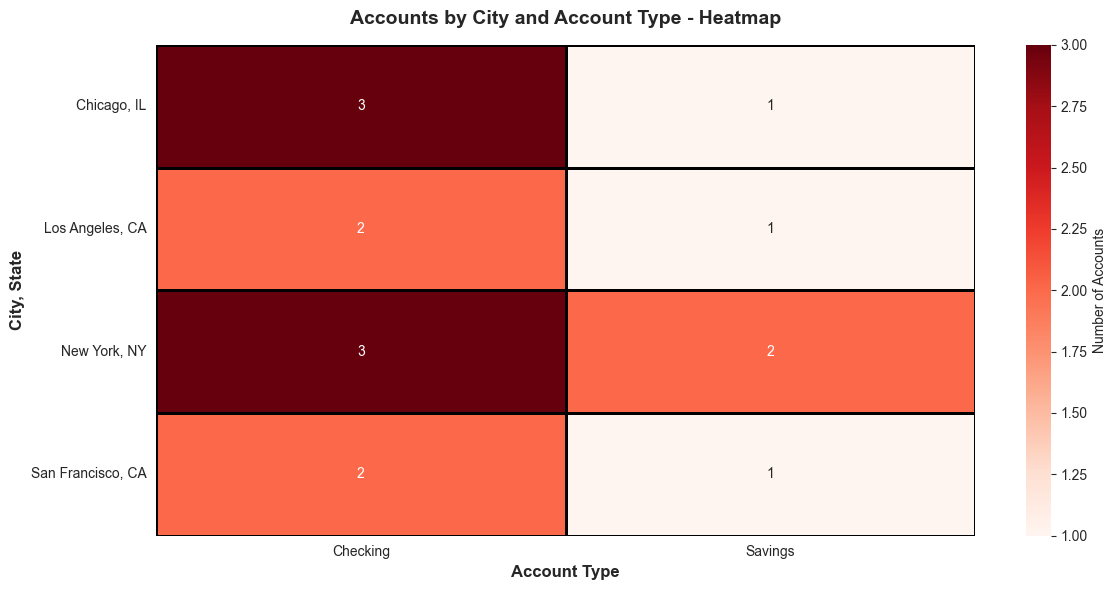


Breakdown by Account Type:
account_type         Checking  Savings
city          state                   
Chicago       IL          3.0      1.0
Los Angeles   CA          2.0      1.0
New York      NY          3.0      2.0
San Francisco CA          2.0      1.0


In [98]:
# Alternative: More detailed heatmap with account types breakdown
account_type_by_city_query = """
SELECT 
    b.city,
    b.state,
    a.account_type,
    COUNT(a.account_id) AS account_count
FROM accounts a
JOIN branches b ON a.branch_id = b.branch_id
GROUP BY b.city, b.state, a.account_type
ORDER BY b.city, a.account_type;
"""

account_type_by_city_df = pd.read_sql_query(account_type_by_city_query, conn)

# Create pivot table for heatmap
if len(account_type_by_city_df) > 0:
    pivot_data = account_type_by_city_df.pivot_table(
        index=['city', 'state'], 
        columns='account_type', 
        values='account_count', 
        fill_value=0
    )
    
    # Create heatmap
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Create labels for rows
    row_labels = [f"{city}, {state}" for city, state in pivot_data.index]
    
    # Create heatmap
    sns.heatmap(pivot_data.values, 
                annot=True, 
                fmt='.0f',
                cmap='Reds',
                cbar_kws={'label': 'Number of Accounts'},
                xticklabels=pivot_data.columns,
                yticklabels=row_labels,
                linewidths=1,
                linecolor='black',
                ax=ax)
    
    ax.set_title('Accounts by City and Account Type - Heatmap', 
                fontsize=14, fontweight='bold', pad=15)
    ax.set_xlabel('Account Type', fontsize=12, fontweight='bold')
    ax.set_ylabel('City, State', fontsize=12, fontweight='bold')
    
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    print("\nBreakdown by Account Type:")
    print(pivot_data.to_string())


## Chicago Customers - Account Type Breakdown

Count customers in Chicago and visualize their account types:


In [99]:
# Query to count customers in Chicago and their account types
chicago_customers_query = """
SELECT 
    c.customer_id,
    c.first_name || ' ' || c.last_name AS customer_name,
    a.account_type,
    COUNT(a.account_id) AS account_count,
    SUM(a.balance) AS total_balance
FROM customers c
JOIN accounts a ON c.customer_id = a.customer_id
WHERE c.city = 'Chicago'
GROUP BY c.customer_id, c.first_name, c.last_name, a.account_type
ORDER BY c.last_name, a.account_type;
"""

# Get the data
chicago_customers_df = pd.read_sql_query(chicago_customers_query, conn)

# Also get total customer count
total_chicago_customers_query = """
SELECT COUNT(DISTINCT c.customer_id) AS total_customers
FROM customers c
WHERE c.city = 'Chicago';
"""

total_customers_df = pd.read_sql_query(total_chicago_customers_query, conn)
total_customers = total_customers_df['total_customers'].iloc[0]

print("="*70)
print(f"TOTAL CUSTOMERS IN CHICAGO: {total_customers}")
print("="*70)
print("\nChicago Customers and Their Account Types:")
print(chicago_customers_df.to_string(index=False))
print("="*70)


TOTAL CUSTOMERS IN CHICAGO: 3

Chicago Customers and Their Account Types:
 customer_id customer_name account_type  account_count  total_balance
           6   Fiona Apple     Checking              1         950.00
          10 Julia Roberts     Checking              1        1450.50
           2    Bob Wilson     Checking              1        3280.75
           2    Bob Wilson      Savings              1        8500.00


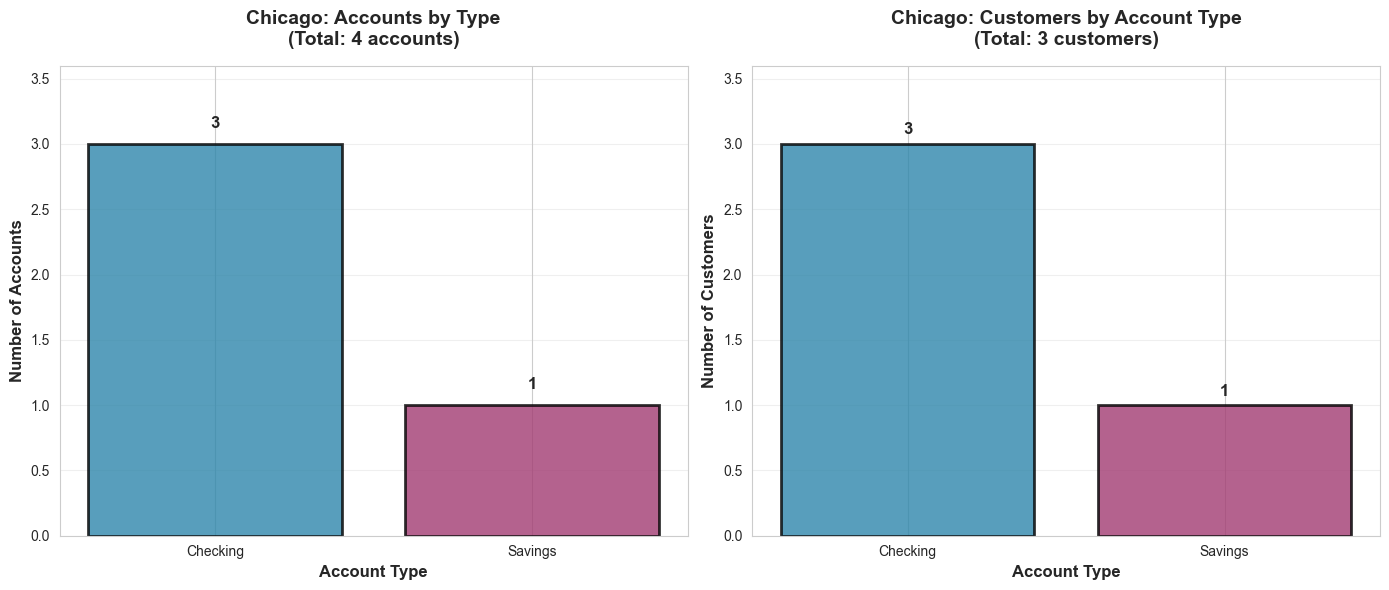


CHICAGO CUSTOMERS - SUMMARY
Total Customers in Chicago: 3
Total Accounts: 4

Breakdown by Account Type:
  Checking: 3 accounts (3 customers)
  Savings: 1 accounts (1 customers)


In [100]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Prepare data for visualization
# Count accounts by type for Chicago customers
account_type_counts = chicago_customers_df.groupby('account_type')['account_count'].sum().reset_index()
account_type_counts.columns = ['Account Type', 'Number of Accounts']

# Count unique customers per account type
customers_per_type = chicago_customers_df.groupby('account_type')['customer_id'].nunique().reset_index()
customers_per_type.columns = ['Account Type', 'Number of Customers']

# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Bar chart showing number of accounts by type
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']
bars1 = ax1.bar(account_type_counts['Account Type'], 
                account_type_counts['Number of Accounts'],
                color=colors[:len(account_type_counts)],
                edgecolor='black',
                linewidth=2,
                alpha=0.8)

# Add value labels on bars
for i, (bar, count) in enumerate(zip(bars1, account_type_counts['Number of Accounts'])):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{int(count)}',
             ha='center', va='bottom', fontweight='bold', fontsize=12)

ax1.set_xlabel('Account Type', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of Accounts', fontsize=12, fontweight='bold')
ax1.set_title(f'Chicago: Accounts by Type\n(Total: {account_type_counts["Number of Accounts"].sum()} accounts)', 
              fontsize=14, fontweight='bold', pad=15)
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim(0, max(account_type_counts['Number of Accounts']) * 1.2)

# Plot 2: Bar chart showing number of customers per account type
bars2 = ax2.bar(customers_per_type['Account Type'], 
                customers_per_type['Number of Customers'],
                color=colors[:len(customers_per_type)],
                edgecolor='black',
                linewidth=2,
                alpha=0.8)

# Add value labels on bars
for i, (bar, count) in enumerate(zip(bars2, customers_per_type['Number of Customers'])):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.05,
             f'{int(count)}',
             ha='center', va='bottom', fontweight='bold', fontsize=12)

ax2.set_xlabel('Account Type', fontsize=12, fontweight='bold')
ax2.set_ylabel('Number of Customers', fontsize=12, fontweight='bold')
ax2.set_title(f'Chicago: Customers by Account Type\n(Total: {total_customers} customers)', 
              fontsize=14, fontweight='bold', pad=15)
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_ylim(0, max(customers_per_type['Number of Customers']) * 1.2)

plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "="*70)
print("CHICAGO CUSTOMERS - SUMMARY")
print("="*70)
print(f"Total Customers in Chicago: {total_customers}")
print(f"Total Accounts: {account_type_counts['Number of Accounts'].sum()}")
print("\nBreakdown by Account Type:")
for _, row in account_type_counts.iterrows():
    customers_with_type = customers_per_type[customers_per_type['Account Type'] == row['Account Type']]['Number of Customers'].iloc[0]
    print(f"  {row['Account Type']}: {int(row['Number of Accounts'])} accounts ({int(customers_with_type)} customers)")
print("="*70)


In [ ]:
# Additional: Detailed view showing each customer and their accounts
chicago_detailed_query = """
SELECT 
    c.first_name || ' ' || c.last_name AS customer_name,
    GROUP_CONCAT(a.account_type || ' (' || a.account_number || ')', ', ') AS accounts
FROM customers c
LEFT JOIN accounts a ON c.customer_id = a.customer_id
WHERE c.city = 'Chicago'
GROUP BY c.customer_id, c.first_name, c.last_name
ORDER BY c.last_name;
"""

chicago_detailed_df = pd.read_sql_query(chicago_detailed_query, conn)

print("\n" + "="*70)
print("CHICAGO CUSTOMERS - DETAILED LIST")
print("="*70)
for idx, row in chicago_detailed_df.iterrows():
    accounts = row['accounts'] if row['accounts'] else 'No accounts'
    print(f"{row['customer_name']}: {accounts}")
print("="*70)


## Accounts by City

Count how many accounts are in each city:


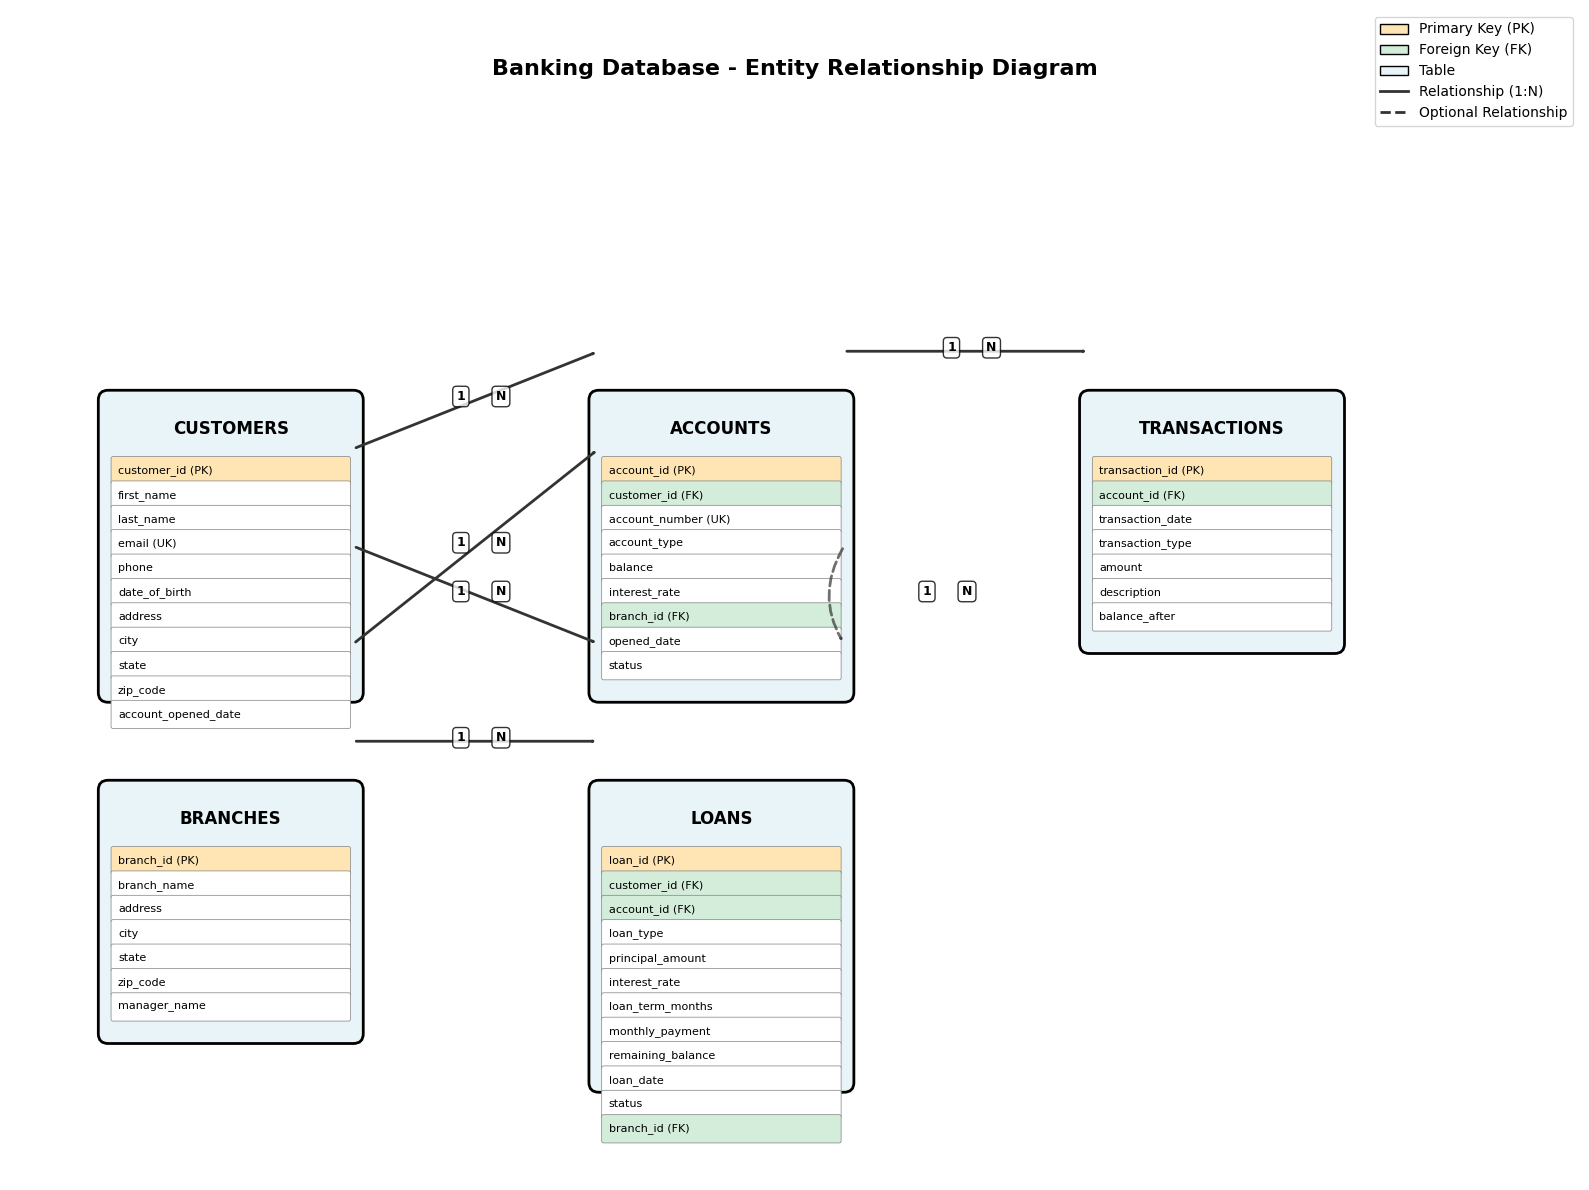

✅ ERD visualization generated!


In [47]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch
import numpy as np

# Create figure
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
ax.set_xlim(0, 16)
ax.set_ylim(0, 12)
ax.axis('off')

# Define colors
table_color = '#E8F4F8'
pk_color = '#FFE5B4'
fk_color = '#D4EDDA'
line_color = '#333333'

# Table positions (x, y, width, height)
tables = {
    'CUSTOMERS': (1, 8, 2.5, 3),
    'BRANCHES': (1, 4, 2.5, 2.5),
    'ACCOUNTS': (6, 8, 2.5, 3),
    'TRANSACTIONS': (11, 8, 2.5, 2.5),
    'LOANS': (6, 4, 2.5, 3)
}

# Table fields
table_fields = {
    'CUSTOMERS': [
        ('customer_id', 'PK'),
        ('first_name', ''),
        ('last_name', ''),
        ('email', 'UK'),
        ('phone', ''),
        ('date_of_birth', ''),
        ('address', ''),
        ('city', ''),
        ('state', ''),
        ('zip_code', ''),
        ('account_opened_date', '')
    ],
    'BRANCHES': [
        ('branch_id', 'PK'),
        ('branch_name', ''),
        ('address', ''),
        ('city', ''),
        ('state', ''),
        ('zip_code', ''),
        ('manager_name', '')
    ],
    'ACCOUNTS': [
        ('account_id', 'PK'),
        ('customer_id', 'FK'),
        ('account_number', 'UK'),
        ('account_type', ''),
        ('balance', ''),
        ('interest_rate', ''),
        ('branch_id', 'FK'),
        ('opened_date', ''),
        ('status', '')
    ],
    'TRANSACTIONS': [
        ('transaction_id', 'PK'),
        ('account_id', 'FK'),
        ('transaction_date', ''),
        ('transaction_type', ''),
        ('amount', ''),
        ('description', ''),
        ('balance_after', '')
    ],
    'LOANS': [
        ('loan_id', 'PK'),
        ('customer_id', 'FK'),
        ('account_id', 'FK'),
        ('loan_type', ''),
        ('principal_amount', ''),
        ('interest_rate', ''),
        ('loan_term_months', ''),
        ('monthly_payment', ''),
        ('remaining_balance', ''),
        ('loan_date', ''),
        ('status', ''),
        ('branch_id', 'FK')
    ]
}

# Draw tables
for table_name, (x, y, w, h) in tables.items():
    # Table box
    table_box = FancyBboxPatch((x, y-h), w, h, 
                               boxstyle="round,pad=0.1", 
                               facecolor=table_color, 
                               edgecolor='black', 
                               linewidth=2)
    ax.add_patch(table_box)
    
    # Table name
    ax.text(x + w/2, y - 0.2, table_name, 
           ha='center', va='top', fontsize=12, fontweight='bold')
    
    # Fields
    field_height = 0.25
    start_y = y - 0.6
    for i, (field, attr) in enumerate(table_fields[table_name]):
        field_y = start_y - i * field_height
        field_color = pk_color if attr == 'PK' else (fk_color if attr == 'FK' else 'white')
        
        # Field box
        field_box = FancyBboxPatch((x + 0.05, field_y - field_height), 
                                   w - 0.1, field_height,
                                   boxstyle="round,pad=0.02",
                                   facecolor=field_color,
                                   edgecolor='gray',
                                   linewidth=0.5)
        ax.add_patch(field_box)
        
        # Field text
        field_text = f"{field}"
        if attr:
            field_text += f" ({attr})"
        ax.text(x + 0.1, field_y - field_height/2, field_text,
               ha='left', va='center', fontsize=8)

# Draw relationships
relationships = [
    # From CUSTOMERS to ACCOUNTS
    ((3.5, 7.5), (6, 8.5), '1', 'N', False),
    # From CUSTOMERS to LOANS
    ((3.5, 6.5), (6, 5.5), '1', 'N', False),
    # From BRANCHES to ACCOUNTS
    ((3.5, 5.5), (6, 7.5), '1', 'N', False),
    # From BRANCHES to LOANS
    ((3.5, 4.5), (6, 4.5), '1', 'N', False),
    # From ACCOUNTS to TRANSACTIONS
    ((8.5, 8.5), (11, 8.5), '1', 'N', False),
    # From ACCOUNTS to LOANS (optional - curved line)
    ((8.5, 6.5), (8.5, 5.5), '1', 'N', True)  # Optional relationship
]

for rel in relationships:
    start, end, card1, card2, is_optional = rel
    if is_optional:
        # Draw curved dashed line for optional relationship (ACCOUNTS to LOANS)
        # Connect from right side of ACCOUNTS to right side of LOANS
        arrow = FancyArrowPatch((8.5, 6.5), (8.5, 5.5),
                               arrowstyle='->', 
                               connectionstyle="arc3,rad=0.3",
                               color=line_color, 
                               linewidth=2,
                               linestyle='--',
                               alpha=0.7)
        ax.add_patch(arrow)
        # Cardinality labels
        mid_x, mid_y = 9.5, 6.0
        ax.text(mid_x - 0.2, mid_y, card1, fontsize=9, fontweight='bold', 
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        ax.text(mid_x + 0.2, mid_y, card2, fontsize=9, fontweight='bold',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    else:
        arrow = FancyArrowPatch(start, end,
                               arrowstyle='->', 
                               color=line_color, 
                               linewidth=2)
        ax.add_patch(arrow)
        # Cardinality labels
        mid_x, mid_y = (start[0] + end[0])/2, (start[1] + end[1])/2
        ax.text(mid_x - 0.2, mid_y, card1, fontsize=9, fontweight='bold',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        ax.text(mid_x + 0.2, mid_y, card2, fontsize=9, fontweight='bold',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Legend
legend_elements = [
    mpatches.Patch(facecolor=pk_color, edgecolor='black', label='Primary Key (PK)'),
    mpatches.Patch(facecolor=fk_color, edgecolor='black', label='Foreign Key (FK)'),
    mpatches.Patch(facecolor=table_color, edgecolor='black', label='Table'),
    plt.Line2D([0], [0], color=line_color, linewidth=2, label='Relationship (1:N)'),
    plt.Line2D([0], [0], color=line_color, linewidth=2, linestyle='--', label='Optional Relationship')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=10)

# Title
ax.text(8, 11.5, 'Banking Database - Entity Relationship Diagram', 
       ha='center', va='top', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()
print("✅ ERD visualization generated!")


In [48]:
# List all tables
%sql SELECT name FROM sqlite_master WHERE type='table';


 * sqlite:///practice_database.db
Done.


,name
0,customers
1,branches
2,accounts
3,transactions
4,loans


## 5 Example Queries

### Example 1: Simple SELECT - View all customers


In [70]:
%%sql
SELECT *
FROM loans
WHERE interest_rate >= 0.0375;

 * sqlite:///practice_database.db
Done.


,loan_id,customer_id,account_id,loan_type,principal_amount,interest_rate,loan_term_months,monthly_payment,remaining_balance,loan_date,status,branch_id
0,1,1,2,Mortgage,350000,0.0375,360,1620.50,345000,2020-02-01,Active,1
1,2,2,4,Auto Loan,25000,0.0450,60,465.25,22000,2019-08-15,Active,2
2,3,4,7,Personal Loan,15000,0.0850,36,475.00,12000,2020-10-01,Active,3
3,5,7,11,Home Equity,75000,0.0550,120,810.50,70000,2020-08-20,Active,4
4,6,9,14,Auto Loan,32000,0.0425,72,495.75,28000,2019-06-05,Active,5


### Example 2: JOIN - Customers with their accounts and balances


In [ ]:
%%sql



 * sqlite:///practice_database.db
Done.


,customer_name,account_number,account_type,balance,branch_name,city
0,George Clooney,SAV007890126,Savings,25000.00,Westside Branch,Los Angeles
1,Ian McKellen,SAV009012348,Savings,18000.00,North Branch,San Francisco
2,Diana Prince,SAV004567893,Savings,15000.00,Financial District,New York
3,Alice Cooper,SAV001234568,Savings,12500.00,Main Street Branch,New York
4,George Clooney,CHK007890125,Checking,11200.75,Westside Branch,Los Angeles
5,Bob Wilson,SAV002345680,Savings,8500.00,Downtown Branch,Chicago
6,Diana Prince,CHK004567892,Checking,6750.00,Financial District,New York
7,Ian McKellen,CHK009012347,Checking,5670.25,North Branch,San Francisco
8,Alice Cooper,CHK001234567,Checking,5420.50,Main Street Branch,New York
9,Edward Norton,CHK005678903,Checking,4200.50,North Branch,San Francisco


### Example 3: Aggregate Functions - Total deposits and withdrawals by account


In [51]:
%%sql
SELECT 
    a.account_number,
    a.account_type,
    COUNT(CASE WHEN t.transaction_type = 'Deposit' THEN 1 END) AS deposit_count,
    SUM(CASE WHEN t.transaction_type = 'Deposit' THEN t.amount ELSE 0 END) AS total_deposits,
    COUNT(CASE WHEN t.transaction_type = 'Withdrawal' THEN 1 END) AS withdrawal_count,
    ABS(SUM(CASE WHEN t.transaction_type = 'Withdrawal' THEN t.amount ELSE 0 END)) AS total_withdrawals
FROM accounts a
LEFT JOIN transactions t ON a.account_id = t.account_id
GROUP BY a.account_id, a.account_number, a.account_type
ORDER BY total_deposits DESC;


 * sqlite:///practice_database.db
Done.


,account_number,account_type,deposit_count,total_deposits,withdrawal_count,total_withdrawals
0,SAV007890126,Savings,1,25000.0,0,0.00
1,SAV009012348,Savings,1,18000.0,0,0.00
2,SAV004567893,Savings,1,15000.0,0,0.00
3,SAV001234568,Savings,2,12500.0,0,0.00
4,CHK007890125,Checking,1,12000.0,1,799.25
5,SAV002345680,Savings,2,8500.0,0,0.00
6,CHK004567892,Checking,1,7000.0,1,250.00
7,CHK001234567,Checking,2,6200.0,2,779.50
8,CHK009012347,Checking,1,6000.0,1,329.75
9,CHK005678903,Checking,1,4500.0,1,299.50


### Example 4: WHERE Filter - High-value accounts (balance > $10,000)

In [52]:
%%sql
SELECT 
    c.first_name || ' ' || c.last_name AS customer_name,
    a.account_number,
    a.account_type,
    a.balance,
    a.interest_rate,
    b.branch_name
FROM accounts a
JOIN customers c ON a.customer_id = c.customer_id
JOIN branches b ON a.branch_id = b.branch_id
WHERE a.balance > 10000
ORDER BY a.balance DESC;


 * sqlite:///practice_database.db
Done.


,customer_name,account_number,account_type,balance,interest_rate,branch_name
0,George Clooney,SAV007890126,Savings,25000.00,0.030,Westside Branch
1,Ian McKellen,SAV009012348,Savings,18000.00,0.025,North Branch
2,Diana Prince,SAV004567893,Savings,15000.00,0.030,Financial District
3,Alice Cooper,SAV001234568,Savings,12500.00,0.025,Main Street Branch
4,George Clooney,CHK007890125,Checking,11200.75,0.000,Westside Branch


### Example 5: Complex JOIN - Customer loan details with account information

In [53]:
%%sql
SELECT 
    c.first_name || ' ' || c.last_name AS customer_name,
    l.loan_type,
    l.principal_amount,
    l.interest_rate * 100 AS interest_rate_pct,
    l.monthly_payment,
    l.remaining_balance,
    a.account_number AS linked_account,
    b.branch_name
FROM loans l
JOIN customers c ON l.customer_id = c.customer_id
LEFT JOIN accounts a ON l.account_id = a.account_id
JOIN branches b ON l.branch_id = b.branch_id
WHERE l.status = 'Active'
ORDER BY l.principal_amount DESC;


 * sqlite:///practice_database.db
Done.


,customer_name,loan_type,principal_amount,interest_rate_pct,monthly_payment,remaining_balance,linked_account,branch_name
0,Edward Norton,Mortgage,425000,3.50,1908.75,410000,CHK005678903,North Branch
1,Alice Cooper,Mortgage,350000,3.75,1620.50,345000,SAV001234568,Main Street Branch
2,George Clooney,Home Equity,75000,5.50,810.50,70000,SAV007890126,Westside Branch
3,Ian McKellen,Auto Loan,32000,4.25,495.75,28000,SAV009012348,North Branch
4,Bob Wilson,Auto Loan,25000,4.50,465.25,22000,SAV002345680,Downtown Branch
5,Diana Prince,Personal Loan,15000,8.50,475.00,12000,SAV004567893,Financial District


## Your Turn!

Write your own SQL queries in the cells below. Use `%%sql` at the top of a cell to run SQL queries.

### Query Ideas:
- Find customers with total account balances over $20,000
- Calculate average account balance by branch
- Find all transactions above $1,000
- List customers with active loans and their monthly payments
- Calculate total loan portfolio value by loan type
- Find accounts with the most transactions
- Calculate interest earned on savings accounts
- Find customers who have both checking and savings accounts
- List all transactions for a specific date range
- Calculate total deposits vs withdrawals by branch
